# Kalman Filter Fun!

### (WIP)

The Kalman filter is a recursive optimal estimation algorithm, designed to solve the discrete-data filtering problem. It has enabled significant advancements in modern control theory, GNC systems, computer vision, signal processing, voice recognition, and much more. I got particularly interested in it after reading about it in "Controls Engineering in the FIRST Robotics Competition" by Tyler Veness. I decided to try making an application of a linear Kalman filter in Python. Luckily, there are lots of robust implementations online so I had plenty of help!

I got much-needed help from The Kalman Filter website (yes, there is an entire website dedicated to this) and Machine Learning Space's implementation

#### A Quick Introduction

A Kalman filter works as a kind of black-box algorithm that can take noisy measurements or sensor data and "fuse" them together to create an estimation of some hidden or unobservable state. For example, if I wanted to determine the position of a car without direct visual access, I would take sensor output from the car's odometer, IMU, and and GPS data. However, if there was some obstacle obstructing the car from accurate GPS tracking, like if I was in some deep tunnel, my GPS data might be muddled and I'd get all sorts of inaccuracies in my car's position. 

A Kalman filter is able to take error and data variance into account and output a prediction of the unknown state - in this case, the car's position. The kick of it is that because it's recursive, it can continue to update dynamically and respond to changes in conditions, and iterate closer and closer to the most accurate state. 

For my project, I decided to try a basic implementation of a linear Kalman filter that uses simulated noisy data as inputs. I followed a tutorial from The Kalman Filter, adapted the code to account for some really weird style and implementation choices, and am currently playing around with this working MVP!

# Working Code (adapted from Kalman Filter tutorial)

C:\Users\nguye\AppData\Local\Temp\ipykernel_27144\798210313.py:110: RuntimeWarning: invalid value encountered in sqrt
  posBound3Sigma.append(3*np.sqrt(posVar))


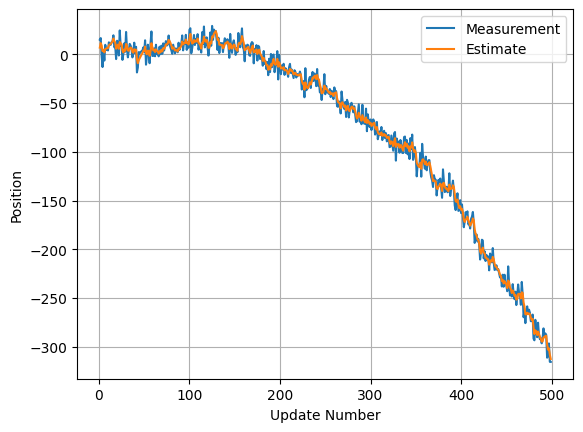

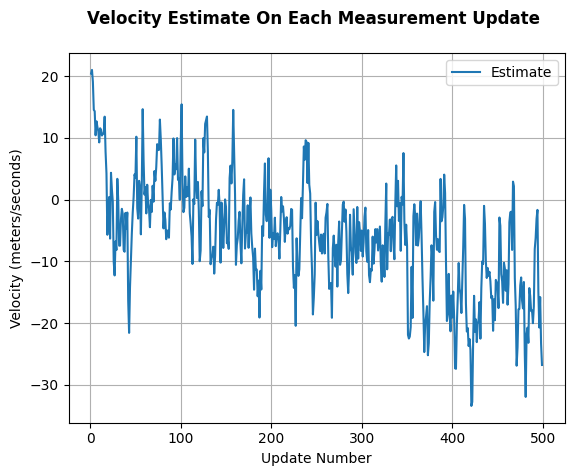

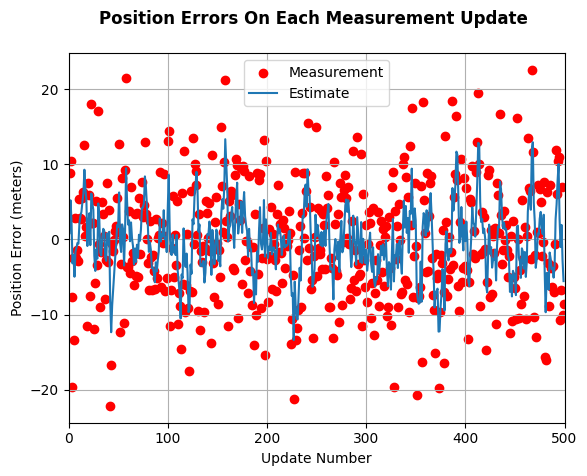

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib

currentPosition = 0
currentVelocity = 60
currentAcceleration = 10

def getMeasurement():
    global currentPosition, currentVelocity, currentAcceleration

    dt = 0.1

    # random noise
    w = 8 * np.random.randn(1)
    v = 8 * np.random.randn(1)
    a = 8 * np.random.randn(1)

    # add random noise to position and velocity
    z = currentVelocity * dt + 0.5 * currentAcceleration * dt**2 + v
    currentAcceleration += a
    currentVelocity = currentVelocity + (currentAcceleration * dt)
    
    # removing noise to compare actual position with estimated position later
    currentPosition = z - v

    return [z, currentPosition, currentVelocity, currentAcceleration]

dt = 0.1

# TODO: Why do these not work as matrices?

# position-velocity matrix
# arbitrary initial values?
x = np.array([[0], [20], [0]]) 

# uncertainty covariance matrix
P = np.array([[5.0, 0, 0], 
              [0, 5, 0],
              [0, 0, 5]])

# state-transition matrix for linearity
A = np.array([[1, dt, 0.5 * dt**2], 
              [0, 1, dt],
              [0, 0, 1]])

# state-to-measurement transition matrix
H = np.array([[1, 0, 0]])

# H transpose
HT = H.T

# input variance
R = 10

# system inaccuracy matrix
Q = np.array([[1.0, 0, 0], 
              [0, 3, 0],
              [0, 0, 1]])

def filter(z):
    global x, P

    # predict state forward
    x_p = A.dot(x)

    # predict covariance forward
    P_p = A.dot(P).dot(A.T) + Q

    # compute kalman gain K
    S = H.dot(P_p).dot(HT) + R
    K = P_p.dot(HT) * (1/S)

    # estimate state
    residual = z - H.dot(x_p)
    x = x_p + K * residual

    # estimate covariance
    P = P_p - K.dot(H).dot(P_p)

    return x[0], x[1], x[2], P

# testing function
def testFilter():
    dt = 0.1
    t = np.linspace(0, 1, num = 500)
    numOfMeasurements = len(t)

    # instantiating...
    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []

    for k in range(1,numOfMeasurements):
        z = getMeasurement()
        # call filter
        f = filter(z[0])
        # store measured and estimated values for pos and vel
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar))

    return measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma

def main():
    t = testFilter()

    plot1 = plt.figure(1)
    plt.plot(t[0], t[1])
    plt.plot(t[0], t[2])
    plt.legend(['Measurement', 'Estimate'])
    plt.ylabel('Position')
    plt.xlabel('Update Number')
    plt.grid(True)

    plot2 = plt.figure(2)
    plt.plot(t[0], t[3])
    plt.ylabel('Velocity (meters/seconds)')
    plt.xlabel('Update Number')
    plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
    plt.legend(['Estimate'])
    plt.grid(True)

    # plot3 = plt.figure(1)
    # plt.plot(t[0], t[1])
    # plt.plot(t[0], t[2])
    # plt.legend(['Measurement', 'Estimate'])
    # plt.ylabel('Position')
    # plt.xlabel('Update Number')
    # plt.grid(True)

    plot4 = plt.figure(3)
    plt.scatter(t[0], t[4], color = 'red')
    plt.plot(t[0], t[5])
    plt.legend(['Measurement', 'Estimate'])
    plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
    #plt.plot(t[0], t[6])
    plt.ylabel('Position Error (meters)')
    plt.xlabel('Update Number')
    plt.grid(True)
    plt.xlim([0, 500])
    plt.show()

main()

The above is the setup for the problem to be solved: a car moving at 60 m/s with instantaneous measurements taken in intervals of `dt = 0.1`. There is a known, constant velocity `currentVelocity` of 60 m/s, with added random noise to simulate real-time measurements. A "sensor" provides a position `currentPosition`, also with added noise. 